<a href="https://colab.research.google.com/github/spretosg/PAREUS_PCA/blob/main/Copy_of_optim_pareus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Optimization PAREUS using NSGA2**
As input we use a shp file containing planning units of the study area. In the simplest form, each planning unit has a cost and a conservation value (e.g. ecosystem service value). THe values are 0-1 normalized.


In [ ]:
!pip install pymoo geopandas shapely


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210078 sha256=c897c9a068388d6553ed060afbb44194b49f5f96d137cc5842a247a25251a704
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [ ]:
import geopandas as gpd
import folium
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from shapely.geometry import Point, Polygon

A base map of all planning units

In [ ]:

# Load features
features = gpd.read_file('fat_pol4.shp')

center_point = features.geometry.unary_union.centroid.coords[0][::-1] # reverse coordinates for folium

# Create a folium map centered on the selected units
m = folium.Map(location=center_point, zoom_start=10)
# Add the selected units to the map
folium.GeoJson(features.geometry.to_crs(epsg=4326)).add_to(m)
#m

# Define a simple optimization problem
Two goals and one constraint

In [ ]:
C = np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]])
n_var = features.shape[0]*features.shape[1]
print(n_var)
#print(features['value'])

26955
0       0.915277
1       0.915442
2       0.821826
3       0.856678
4       0.915326
          ...   
8980    0.975109
8981    0.973410
8982    0.972192
8983    0.970168
8984    0.972054
Name: value, Length: 8985, dtype: float64


In [ ]:
class SpatialOptimizationProblem(Problem):
    def __init__(self, features):
        super().__init__(n_var=len(features),
                         n_obj=2,
                         n_ieq_constr=1,
                         xl=0,
                         xu=1,
                         type_var=bool)
        self.features = features

    def _evaluate(self, x, out, *args, **kwargs):
        costs = self.features['cost'].values
        conservation_values = self.features['value'].values

        # Objective 1: Minimize cost
        f1 = np.sum(x * costs, axis=1)

        # Objective 2: Maximize conservation value
        f2 = -np.sum(x * conservation_values, axis=1)

        # constraint: 20 cells
        #g1 = np.sum(x,axis=1)-100

        out["F"] = np.column_stack([f1, f2])

        # Constraint: Total cost should not exceed max_cost (e.g. 10000)
        g1 = np.sum(x*costs, axis=1)-3000
        out["G"] = [g1]


In [ ]:
max_cost = 100
problem = SpatialOptimizationProblem(features)


Apply NSGA2 algorithm with a population and some mutation parameters

In [ ]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=12)

algorithm = NSGA3(
    pop_size=90,
    n_offsprings=10,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
    ref_dirs=ref_dirs
)


#print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))


Some generations for testing should be sufficient

In [ ]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 50)
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       90 |      5 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      100 |      3 |  0.000000E+00 |  0.000000E+00 |  0.8272865453 |         ideal
     3 |      110 |      6 |  0.000000E+00 |  0.000000E+00 |  0.1680379261 |             f
     4 |      120 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0125771046 |             f
     5 |      130 |      7 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      140 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0399591055 |             f
     7 |      150 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0106481845 |             f
     8 |      160 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0159165014 |             f
     9 |      170 |      9 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |      180 |      8 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

[[ 1618.29456882 -2211.09294006]
 [ 2050.20020187 -2841.85754148]
 [ 2322.9312639  -3143.15659076]
 [ 2089.81905195 -2933.72531695]
 [ 1734.89773556 -2375.28591454]
 [ 1676.23042344 -2288.89975843]
 [ 2238.90602953 -3066.84582523]
 [ 1841.36880409 -2567.1939447 ]
 [ 1784.89729992 -2479.24238486]
 [ 2169.96063325 -2995.34470286]
 [ 1992.28322192 -2775.00995062]
 [ 1943.92198321 -2731.71020177]]


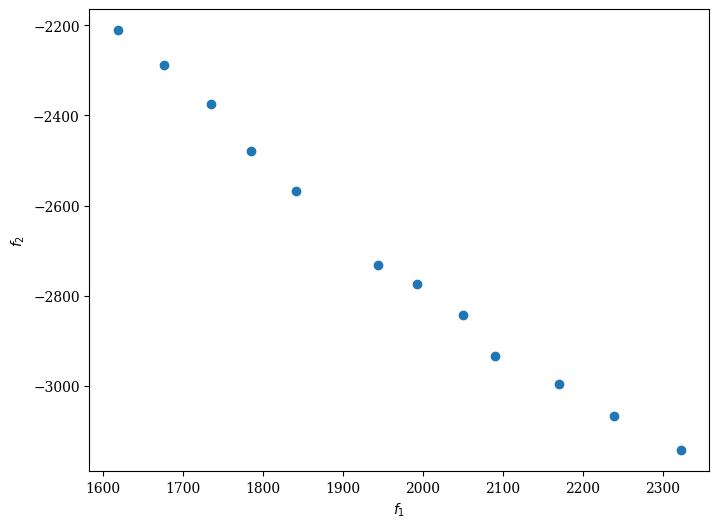

In [ ]:
plot = Scatter()
plot.add(res.F)
print(res.F)
plot.show()


In [ ]:
import matplotlib.pyplot as plt
import folium
# Extract the best solution (or any desired solution)
best_solution = res.X[np.argmin(res.F[:, 0])]  # Minimize cost (change criteria as needed)

# Convert the best solution to a GeoDataFrame for plotting
selected_units = features[best_solution == 1]

#print(selected_units)
# Calculate the center of the selected units for map initialization
center_point = selected_units.geometry.unary_union.centroid.coords[0][::-1] # reverse coordinates for folium

# Create a folium map centered on the selected units
m = folium.Map(location=center_point, zoom_start=10)

# Add the selected units to the map
folium.GeoJson(selected_units.geometry.to_crs(epsg=4326)).add_to(m)

# Display the map
m
#print(len(selected_units))


Connectivity

In [ ]:
from shapely.ops import unary_union
class SpatialOptimizationProblem(Problem):
    def __init__(self, features):
        super().__init__(n_var=len(features),
                         n_obj=2,
                         n_constr=2,  # Two constraints
                         xl=0,
                         xu=1,
                         type_var=bool)
        self.features = features



    def _evaluate(self, x, out, *args, **kwargs):
        costs = self.features['cost'].values
        conservation_values = self.features['value'].values
        # Objective 1: Minimize cost
                # Objective 1: Minimize cost
        f1 = np.sum(x * costs, axis=1)

        # Objective 2: Maximize conservation value
        f2 = -np.sum(x * conservation_values, axis=1)

        out["F"] = [f1, f2]

        # Constraint: Total cost should not exceed max_cost
        g1 = np.sum(x*costs) - 10000 # Use boolean indexing for cost constraint

        # Constraint 2: Ensure connectivity
        g2 = 0 # Initialize g2 as a scalar
        selected_units = self.features.iloc[x]
        if not selected_units.empty:
            merged_geom = unary_union(selected_units.geometry)
            if hasattr(merged_geom, 'geoms'):  # Check if it's a MultiPolygon
                g2 = len(selected_units) - len(merged_geom.geoms)
            else:  # It's a single Polygon
                g2 = len(selected_units) - 1  # Single polygon means all are connected


        out["G"] = [g1, g2] # g2 is now a single value r

In [ ]:
from pymoo.optimize import minimize

problem = SpatialOptimizationProblem(features)
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Run the optimization
res = minimize(
    problem,
    algorithm,
    ('n_gen', 30),
    seed=1,
    verbose=True
)

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)